In [1]:
from optim_relu_max_linear import OptimReluMaxLinear
from check_grad_optim_v import test_optim_splade_model
import triton
import torch

In [ ]:
test_optim_splade_model()

In [2]:
x_vals = []
for i in range(1, 11):
    x_vals.append([2000 * i, 64, 32, 300])

In [3]:
configs = []

configs.append(
    triton.testing.Benchmark(
        x_names=["V", "B", "L", "D"],  # Argument names to use as an x-axis for the plot
        x_vals=x_vals,  # Different possible values for `x_name`
        line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        # Don't compare to cublas for fp8 cases as torch.matmul doesn't support fp8 at the moment.
        line_vals= ["torch", "triton"],  # Label name for the lines
        line_names= ["torch", "Triton"],  # Line styles
        styles=[("green", "-"), ("blue", "-")],
        ylabel="GB/s",  # Label name for the y-axis
        plot_name="relu_max_backward_performance",
        args={},
    ))


In [4]:
@triton.testing.perf_report(configs)
def benchmark(B, L, D, V, provider):
    x = torch.randn(B, L, D, requires_grad=True, dtype=torch.float64, device='cuda')
    w = torch.randn(D, V, requires_grad=True, dtype=torch.float64, device='cuda')
    b = torch.randn(V, requires_grad=True, dtype=torch.float64, device='cuda')
    list_lengths = torch.randint(0, L, [B])
    mask = torch.ones(B, L).cuda()
    for i, l in enumerate(list_lengths):
        mask[i, l:] = 0
        
    mask_inf = torch.where(mask == 1, 0, -torch.inf)
    relu = torch.nn.ReLU()
    
    torch_calculation = relu(torch.max((x @ w) + b.reshape(1, 1, *b.shape) + mask_inf.reshape(*mask_inf.shape, 1), dim=1)[0])
    triton_calculation = OptimReluMaxLinear.apply(x, w, b, mask)[0]
        
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch_calculation.sum().backward(retain_graph=True), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_calculation.sum().backward(retain_graph=True) , quantiles=quantiles)
    gbps = lambda ms: B * L * D * V / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

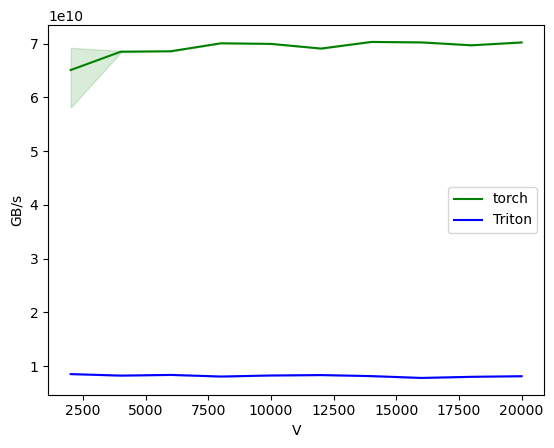

relu_max_backward_performance:
         V     B     L      D         torch        Triton
0   2000.0  64.0  32.0  300.0  6.508640e+10  8.533394e+09
1   4000.0  64.0  32.0  300.0  6.849700e+10  8.252272e+09
2   6000.0  64.0  32.0  300.0  6.858082e+10  8.380474e+09
3   8000.0  64.0  32.0  300.0  7.006481e+10  8.079462e+09
4  10000.0  64.0  32.0  300.0  6.994719e+10  8.274310e+09
5  12000.0  64.0  32.0  300.0  6.908264e+10  8.350769e+09
6  14000.0  64.0  32.0  300.0  7.031525e+10  8.159127e+09
7  16000.0  64.0  32.0  300.0  7.023088e+10  7.818423e+09
8  18000.0  64.0  32.0  300.0  6.969135e+10  8.027018e+09
9  20000.0  64.0  32.0  300.0  7.022020e+10  8.140588e+09


In [5]:
benchmark.run(show_plots=True, print_data=True)